In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import streamlit as st
from PIL import Image
import numpy as np
import tensorflow as tf
import openai

### Data Augmentation and Loading

In [3]:
DATASET_ROOT = r"E:\kaggle multicrop dataset"  
DATA_TYPE_FOLDER = "RGB_224x224"

TRAIN_DIR = os.path.join(DATASET_ROOT, DATA_TYPE_FOLDER, "train")
VAL_DIR   = os.path.join(DATASET_ROOT, DATA_TYPE_FOLDER, "val")
TEST_DIR  = os.path.join(DATASET_ROOT, DATA_TYPE_FOLDER, "test")

In [4]:
print("Train dir exists:", os.path.exists(TRAIN_DIR))
print("Val dir exists:", os.path.exists(VAL_DIR))
print("Test dir exists:", os.path.exists(TEST_DIR))

Train dir exists: True
Val dir exists: True
Test dir exists: True


In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=30,
    zoom_range=0.2
)

train_gen = datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    directory=VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    directory=TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

NUM_CLASSES = train_gen.num_classes
CLASS_LABELS = list(train_gen.class_indices.keys())

Found 27639 images belonging to 139 classes.
Found 6422 images belonging to 139 classes.
Found 6627 images belonging to 139 classes.


In [6]:
CLASS_LABELS

['Aji pepper plant',
 'Almonds plant',
 'Amaranth plant',
 'Apples plant',
 'Artichoke plant',
 'Avocados plant',
 'Bananas plant',
 'Barley plant',
 'Beets plant',
 'Black pepper plant',
 'Blueberries plant',
 'Bok choy plant',
 'Brazil nuts plant',
 'Broccoli plant',
 'Brussels sprout plant',
 'Buckwheat plant',
 'Cabbages and other brassicas plant',
 'Camucamu plant',
 'Carrots and turnips plant',
 'Cashew nuts plant',
 'Cassava plant',
 'Cauliflower plant',
 'Celery plant',
 'Cherimoya plant',
 'Cherry plant',
 'Chestnuts plant',
 'Chickpeas plant',
 'Chili peppers and green peppers plant',
 'Cinnamon plant',
 'Cloves plant',
 'Cocoa beans plant',
 'Coconuts plant',
 'Coffee (green) plant',
 'Collards plant',
 'Cotton lint plant',
 'Cranberries plant',
 'Cucumbers and gherkins plant',
 'Dates plant',
 'Dry beans plant',
 'Dry peas plant',
 'Durian plant',
 'Eggplants (Aubergines) plant',
 'Endive plant',
 'Fava bean plant',
 'Figs plant',
 'Flax fiber and tow plant',
 'Flaxseed (Li

### Exploratory Data Analysis (EDA)

#### Visualizing Class Balance

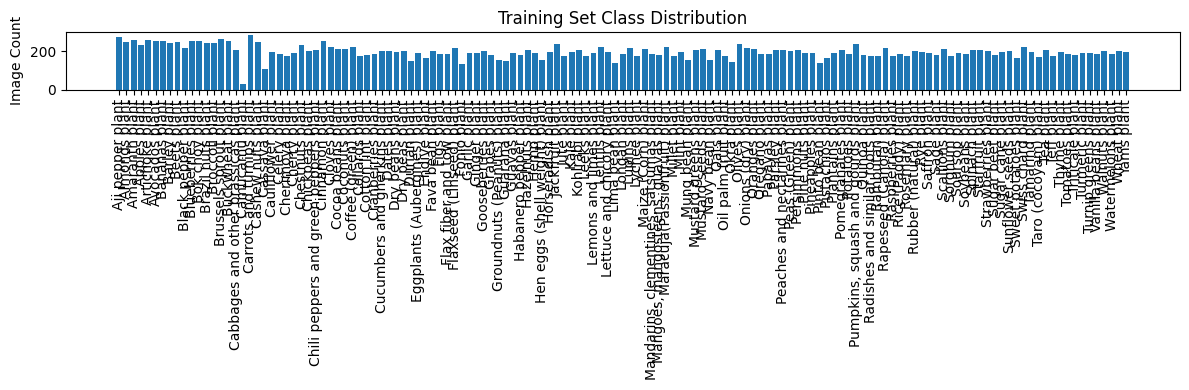

In [7]:
%matplotlib inline

counts = np.bincount(train_gen.classes)
plt.figure(figsize=(12,4))
plt.bar(CLASS_LABELS, counts)
plt.xticks(rotation=90)
plt.title('Training Set Class Distribution')
plt.ylabel('Image Count')
plt.tight_layout()
plt.show()


#### Display Example Images

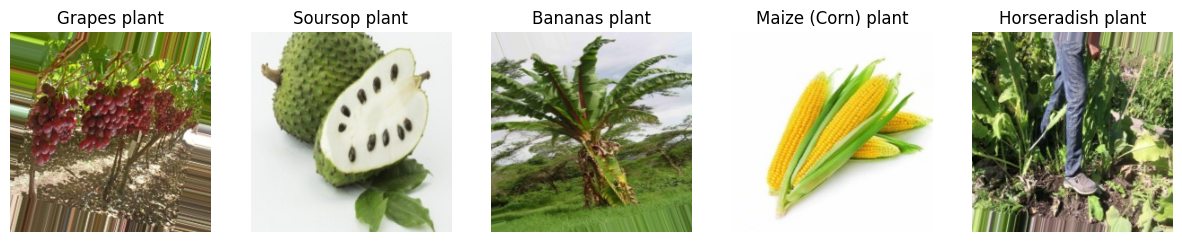

In [22]:
def plot_sample_images(gen, n=5):
    images, labels = next(gen)
    plt.figure(figsize=(15,3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i])
        plt.title(CLASS_LABELS[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()

plot_sample_images(train_gen)


### Model Building and Training

#### Transfer learning with Pre-trained Models MobileNetV2

In [ ]:
base_model = MobileNetV2(input_shape=(*IMG_SIZE, 3), weights='imagenet', include_top=False)
base_model.trainable = False  # Freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

#Early stopping and model checkpointing
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=callbacks
)


C:\Users\Aryan Aarav\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
864/864 ━━━━━━━━━━━━━━━━━━━━ 799s 921ms/step - accuracy: 0.1250 - loss: 4.2351 - val_accuracy: 0.3130 - val_loss: 3.0270
Epoch 2/30
864/864 ━━━━━━━━━━━━━━━━━━━━ 565s 654ms/step - accuracy: 0.3095 - loss: 3.0509 - val_accuracy: 0.3711 - val_loss: 2.7673
Epoch 3/30
864/864 ━━━━━━━━━━━━━━━━━━━━ 571s 661ms/step - accuracy: 0.3600 - loss: 2.7666 - val_accuracy: 0.4036 - val_loss: 2.6241
Epoch 4/30
864/864 ━━━━━━━━━━━━━━━━━━━━ 572s 662ms/step - accuracy: 0.3865 - loss: 2.5994 - val_accuracy: 0.4045 - val_loss: 2.5900
Epoch 5/30
864/864 ━━━━━━━━━━━━━━━━━━━━ 571s 661ms/step - accuracy: 0.3990 - loss: 2.5050 - val_accuracy: 0.4248 - val_loss: 2.5548
Epoch 6/30
864/864 ━━━━━━━━━━━━━━━━━━━━ 573s 663ms/step - accuracy: 0.4166 - loss: 2.4086 - val_accuracy: 0.4383 - val_loss: 2.4833
Epoch 7/30
864/864 ━━━━━━━━━━━━━━━━━━━━ 573s 663ms/step - accuracy: 0.4402 - loss: 2.2999 - val_accuracy: 0.4391 - val_loss: 2.4659
Epoch 8/30
864/864 ━━━━━━━━━━━━━━━━━━━━ 571s 661ms/step - accuracy: 0.4477 -

#### Fine Tuning the Model

In [9]:
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history_fine = model.fit(
    train_gen,
    epochs=10,  # Fewer epochs for fine-tuning
    validation_data=val_gen,
    callbacks=callbacks
)


Epoch 1/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2045s 2s/step - accuracy: 0.2651 - loss: 3.4031 - val_accuracy: 0.4260 - val_loss: 2.6459
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 1913s 2s/step - accuracy: 0.4000 - loss: 2.5183 - val_accuracy: 0.4615 - val_loss: 2.4508
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 1861s 2s/step - accuracy: 0.4384 - loss: 2.2939 - val_accuracy: 0.4829 - val_loss: 2.3356
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2009s 2s/step - accuracy: 0.4682 - loss: 2.1432 - val_accuracy: 0.4921 - val_loss: 2.2508
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 1822s 2s/step - accuracy: 0.4883 - loss: 2.0873 - val_accuracy: 0.5081 - val_loss: 2.2001
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 1768s 2s/step - accuracy: 0.5062 - loss: 1.9773 - val_accuracy: 0.5226 - val_loss: 2.1482
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 1824s 2s/step - accuracy: 0.5212 - loss: 1.9036 - val_accuracy: 0.5235 - val_loss: 2.1296
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 1759s 2s/step - accuracy: 0.5248 - loss: 1.8921 - 

In [ ]:
model.save('final_trained_model.keras')

### Model Evaluation

In [9]:
model = tf.keras.models.load_model('final_trained_model.keras')

In [19]:
# Save weights in HDF5 format (Keras 3.x+ requirement)
model.save_weights('model_weights.weights.h5')

#### Accuracy, F1 Score, Confusion Matrix

C:\Users\Aryan Aarav\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


201/201 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step
                                        precision    recall  f1-score   support

                      Aji pepper plant       0.69      0.79      0.73        84
                         Almonds plant       0.54      0.53      0.54        75
                        Amaranth plant       0.74      0.77      0.75        77
                          Apples plant       0.62      0.47      0.54        70
                       Artichoke plant       0.88      0.90      0.89        79
                        Avocados plant       0.61      0.73      0.67        74
                         Bananas plant       0.60      0.73      0.65        77
                          Barley plant       0.40      0.47      0.43        70
                           Beets plant       0.65      0.68      0.66        75
                    Black pepper plant       0.71      0.53      0.61        68
                     Blueberries plant       0.77      0.87      0.82        

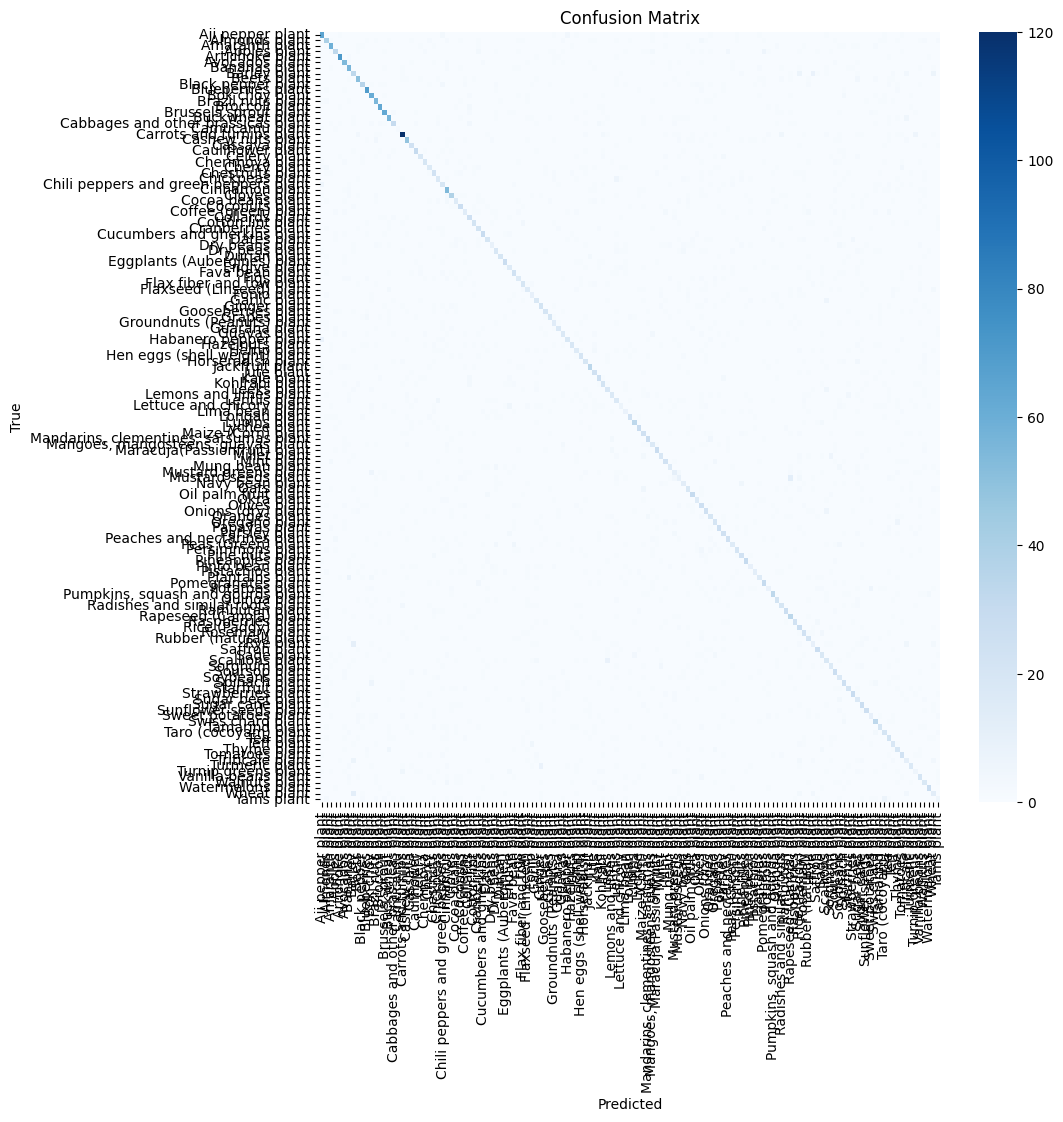

In [10]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Predict validation labels
val_gen.reset()
preds = model.predict(val_gen)
y_true = val_gen.classes
y_pred = np.argmax(preds, axis=1)

# Classification report
print(classification_report(y_true, y_pred, target_names=CLASS_LABELS))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_pred)
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Model Explanability with Grad-CAM

#### GRAD-CAM Visualization

C:\Users\Aryan Aarav\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: [['input_layer']]. Received: the structure of inputs=*
  warnings.warn(


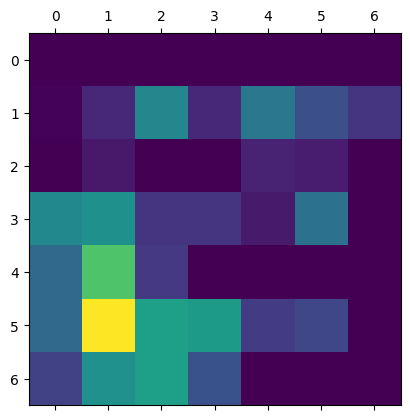

In [11]:
import tensorflow as tf
import matplotlib.cm as cm
import numpy as np # Make sure numpy is imported

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)

        
        if isinstance(preds, list):
            preds = preds[0]

        
        preds_tensor = tf.squeeze(preds)

        
        pred_index = tf.argmax(preds_tensor)
        
        
        class_channel = preds_tensor[pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon()) # Added epsilon for stability
    return heatmap.numpy()


IMG_SIZE = (224, 224)
img_path = r"E:\kaggle multicrop dataset\RGB_224x224\test\Aji pepper plant\1.jpg"
img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)


heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name='Conv_1')

plt.matshow(heatmap)
plt.show()

### Deployment as a Web Application using Streamlit

#### Stereamlit Classficiation App

In [17]:
import streamlit as st
from PIL import Image
import numpy as np
import tensorflow as tf


model = tf.keras.models.load_model('final_trained_model.keras')

CLASS_LABELS = ['Aji pepper plant',
 'Almonds plant',
 'Amaranth plant',
 'Apples plant',
 'Artichoke plant',
 'Avocados plant',
 'Bananas plant',
 'Barley plant',
 'Beets plant',
 'Black pepper plant',
 'Blueberries plant',
 'Bok choy plant',
 'Brazil nuts plant',
 'Broccoli plant',
 'Brussels sprout plant',
 'Buckwheat plant',
 'Cabbages and other brassicas plant',
 'Camucamu plant',
 'Carrots and turnips plant',
 'Cashew nuts plant',
 'Cassava plant',
 'Cauliflower plant',
 'Celery plant',
 'Cherimoya plant',
 'Cherry plant',
 'Chestnuts plant',
 'Chickpeas plant',
 'Chili peppers and green peppers plant',
 'Cinnamon plant',
 'Cloves plant',
 'Cocoa beans plant',
 'Coconuts plant',
 'Coffee (green) plant',
 'Collards plant',
 'Cotton lint plant',
 'Cranberries plant',
 'Cucumbers and gherkins plant',
 'Dates plant',
 'Dry beans plant',
 'Dry peas plant',
 'Durian plant',
 'Eggplants (Aubergines) plant',
 'Endive plant',
 'Fava bean plant',
 'Figs plant',
 'Flax fiber and tow plant',
 'Flaxseed (Linseed) plant',
 'Fonio plant',
 'Garlic plant',
 'Ginger plant',
 'Gooseberries plant',
 'Grapes plant',
 'Groundnuts (Peanuts) plant',
 'Guarana plant',
 'Guavas plant',
 'Habanero pepper plant',
 'Hazelnuts plant',
 'Hemp plant',
 'Hen eggs (shell weight) plant',
 'Horseradish plant',
 'Jackfruit plant',
 'Jute plant',
 'Kale plant',
 'Kohlrabi plant',
 'Leeks plant',
 'Lemons and limes plant',
 'Lentils plant',
 'Lettuce and chicory plant',
 'Lima bean plant',
 'Longan plant',
 'Lupins plant',
 'Lychee plant',
 'Maize (Corn) plant',
 'Mandarins, clementines, satsumas plant',
 'Mangoes, mangosteens, guavas plant',
 'Maracuja(Passionfruit) plant',
 'Millet plant',
 'Mint plant',
 'Mung bean plant',
 'Mustard greens plant',
 'Mustard seeds plant',
 'Navy bean plant',
 'Oats plant',
 'Oil palm fruit plant',
 'Okra plant',
 'Olives plant',
 'Onions (dry) plant',
 'Oranges plant',
 'Oregano plant',
 'Papayas plant',
 'Parsley plant',
 'Peaches and nectarines plant',
 'Peas (Green) plant',
 'Persimmons plant',
 'Pine nuts plant',
 'Pineapples plant',
 'Pinto bean plant',
 'Pistachios plant',
 'Plantains plant',
 'Pomegranates plant',
 'Potatoes plant',
 'Pumpkins, squash and gourds plant',
 'Quinoa plant',
 'Radishes and similar roots plant',
 'Rambutan plant',
 'Rapeseed (Canola) plant',
 'Raspberries plant',
 'Rice (Paddy) plant',
 'Rosemary plant',
 'Rubber (natural) plant',
 'Rye plant',
 'Saffron plant',
 'Sage plant',
 'Scallions plant',
 'Sorghum plant',
 'Soursop plant',
 'Soybeans plant',
 'Spinach plant',
 'Starfruit plant',
 'Strawberries plant',
 'Sugar beet plant',
 'Sugar cane plant',
 'Sunflower seeds plant',
 'Sweet potatoes plant',
 'Swiss chard plant',
 'Tamarind plant',
 'Taro (cocoyam) plant',
 'Tea plant',
 'Teff plant',
 'Thyme plant',
 'Tomatoes plant',
 'Triticale plant',
 'Turmeric plant',
 'Turnip greens plant',
 'Vanilla beans plant',
 'Walnuts plant',
 'Watermelons plant',
 'Wheat plant',
 'Yams plant']  # Fill with your actual 139 class names

def preprocess_image(img):
    img = img.resize(IMG_SIZE)
    arr = np.array(img) / 255.0
    if arr.shape[-1] == 4:  # Handle PNG with alpha
        arr = arr[..., :3]
    arr = np.expand_dims(arr, 0)
    return arr

def get_crop_advice(crop_name):
    prompt = f"Give agronomic care tips for the crop: {crop_name}"
    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content

# Integrating GRAD-CAM visualization in Streamlit App

st.title("Multi-Crop Plant Recognition System")
uploaded_file = st.file_uploader("Upload a plant image:", type=["jpg", "jpeg", "png"])
if uploaded_file:
    img = Image.open(uploaded_file).convert('RGB')
    st.image(img, caption='Uploaded Crop Leaf', use_column_width=True)
    arr = preprocess_image(img)
    preds = model.predict(arr)
    idx = np.argmax(preds)
    conf = preds[0, idx]
    st.success(f"Prediction: {CLASS_LABELS[idx]} ({conf*100:.2f}% confidence)")

    if st.button("Show Explainability"):
        heatmap = make_gradcam_heatmap(arr, model, last_conv_layer_name='Conv_1')
        heatmap_img = cm.jet(heatmap)[..., :3]
        st.image(heatmap_img, caption="Grad-CAM Heatmap", use_column_width=True)

    
    if st.button("Get Agronomic Advice"):
        tips = get_crop_advice(CLASS_LABELS[idx])
        st.write(tips)

2025-09-24 22:19:58.574 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-24 22:19:58.574 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-24 22:19:58.575 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-24 22:19:58.575 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-24 22:19:58.576 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-24 22:19:58.576 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-24 22:19:58.577 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-24 22:19:58.577 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [20]:
# cd "d:\Projects\Multi-Crop Plant Recoginition for Smart Agriculture Using Deep Learning"
# python -m streamlit run app.py
